In [454]:
%matplotlib inline
import numpy as np
from lsst.daf.persistence import Butler
butler = Butler('/datasets/hsc/repo/rerun/DM-13666/DEEP')

In [455]:
sky_map = butler.get('deepCoadd_skyMap')

In [456]:
import numpy as np

class ArbitrarySkyQuery(object):

    def __init__(self, butler):
    
        self.butler = butler
        self.sky_map = self.butler.get('deepCoadd_skyMap')
    
        # an array of the centers of all tracts (Cartesian)
        self.tract_center_array = np.zeros((len(sky_map), 3), dtype=float)

        # an array of the angular radii of all tracts (in degrees)
        self.tract_radius_array = np.zeros(len(sky_map), dtype=float)

        # a dict keyed on tract id that gives the cartesian centers
        # of all patches
        self.tract_patch_centers = {}
        self.tract_patch_radii = {}

        # a dict that will associate the integer id of a patch
        # in self.tract_patch_center_dict[tract_id] with the
        # (ix, iy) identity of the patch
        self.tract_patch_lookup = {}
        self.tract_patch_initialized = {}

        for ii in range(len(self.sky_map)):
            tract = self.sky_map[ii]
            wcs = tract.getWcs()
            bbox = tract.getBBox()

            tract_center = np.array(tract.getCtrCoord().getVector())                          
               
            dist_max = None
            for xx in [bbox.getMinX(), bbox.getMaxX()]:
                for yy in [bbox.getMinY(), bbox.getMaxY()]:
                    sky_pt = np.array(wcs.pixelToSky(xx, yy).getVector())
                    dp = np.dot(tract_center, sky_pt)
                    rr = np.abs(np.arccos(dp))
                    if dist_max is None or rr>dist_max:
                        dist_max = rr
            self.tract_radius_array[ii] = np.degrees(dist_max)
 
            self.tract_center_array[ii] = tract_center
            patch_grid_dim = tract.getNumPatches()
            self.tract_patch_lookup[ii] = []
            self.tract_patch_initialized[ii] = False
            ct = 0
            for i1 in range(patch_grid_dim[0]):
                for i2 in range(patch_grid_dim[1]):
                    self.tract_patch_lookup[ii].append((i1,i2))
                    ct += 1
            self.tract_patch_lookup[ii] = np.array(self.tract_patch_lookup[ii])
            self.tract_patch_centers[ii] = np.zeros((ct,3), dtype=float)
            self.tract_patch_radii[ii] = np.zeros(ct, dtype=float)

    def find_tracts(self, ra, dec, angular_radius):
        """
        ra, dec, angular radius are all in degrees
        """
        ra_rad = np.radians(ra)
        dec_rad = np.radians(dec)
        xyz = np.array([np.cos(dec_rad)*np.cos(ra_rad),
                        np.cos(dec_rad)*np.sin(ra_rad),
                        np.sin(dec_rad)])
        dot_prod = np.dot(self.tract_center_array, xyz)
        valid = np.where(dot_prod>np.cos(np.radians(angular_radius +
                                                    self.tract_radius_array)))

        print('valid dot')
        print(dot_prod[valid])
        for i_valid in valid[0]:
            print(np.dot(xyz,self.tract_center_array[i_valid]))
        return valid
    
    def _initialize_patch_coords(self, tract_id):
        """
        compute the centers and radii for the patches in a tract

        tract_id is an integer denoting the tract we are dealing with
        """
        if self.tract_patch_initialized[tract_id]:
            return
        print('initializing ',tract_id)
        tract = self.sky_map[tract_id]
        wcs = tract.getWcs()

        xyz_array = np.zeros((4,3), dtype=float)
        for ii in range(len(self.tract_patch_lookup[tract_id])):
            patch_id = self.tract_patch_lookup[tract_id][ii]
            patch = tract[patch_id[0], patch_id[1]]
            bbox = patch.getOuterBBox()
            ct = 0
            for xx in [bbox.getMinX(), bbox.getMaxX()]:
                for yy in [bbox.getMinY(), bbox.getMaxY()]:
                    sky = np.array(wcs.pixelToSky(xx, yy).getVector())
                    xyz_array[ct] = sky
                    ct += 1
            center_xyz = np.array([np.mean(xyz_array[:,0]),
                                   np.mean(xyz_array[:,1]),
                                   np.mean(xyz_array[:,2])])
            self.tract_patch_centers[tract_id][ii] = center_xyz
            
            dist_max = None
            for xyz in xyz_array:
                dp = np.dot(xyz, center_xyz)
                rr = np.degrees(np.abs(np.arccos(dp)))
                if dist_max is None or rr> dist_max:
                    dist_max = rr
            self.tract_patch_radii[tract_id][ii] = dist_max

        self.tract_patch_initialized[tract_id] = True
    
    def find_patches(self, ra, dec, angular_distance, tract_id):
        """
        ra -- ra of boresite in degrees
        dec -- dec of boresite in degrees
        angular_distance -- radius of patch of sky in degrees
        tract_id -- integer ID of the tract being considered
        
        returns:
        --------
        A 2-D list.  Each row contains the ix, iy indices of
        patches that may overlap the region
        """
        if not self.tract_patch_initialized[tract_id]:
            self._initialize_patch_coords(tract_id)
        
        ra_rad = np.radians(ra)
        dec_rad = np.radians(dec)
        xyz = np.array([np.cos(dec_rad)*np.cos(ra_rad),
                        np.cos(dec_rad)*np.sin(ra_rad),
                        np.sin(dec_rad)])
        
        patch_centers = self.tract_patch_centers[tract_id]
        patch_radii = self.tract_patch_radii[tract_id]
        valid = np.where(np.dot(patch_centers, xyz) >
                         np.cos(np.radians(patch_radii+angular_distance)))
        return self.tract_patch_lookup[tract_id][valid]
    
    def get_forced_sources(self, ra, dec, angular_distance):
        valid_tracts = self.find_tracts(ra, dec, angular_distance)
        patches = {}
        output = {}
        ra_rad = np.radians(ra)
        dec_rad = np.radians(dec)
        xyz_pointing = np.array([np.cos(dec_rad)*np.cos(ra_rad),
                                 np.cos(dec_rad)*np.sin(ra_rad),
                                 np.sin(dec_rad)])
        for tract_id in valid_tracts[0]:
            patches = self.find_patches(ra, dec, angular_distance, tract_id)
            if len(patches)>0:
                for patch in patches:
                    dataId = {'filter':'HSC-R', 'tract':tract_id,
                              'patch':'%d,%d' % (patch[0],patch[1])}
                    if self.butler.datasetExists('deepCoadd_forced_src', dataId=dataId):
                        data = butler.get('deepCoadd_forced_src', dataId=dataId)
                        cos_ra = np.cos(data['coord_ra'])
                        cos_dec = np.cos(data['coord_dec'])
                        sin_ra = np.sin(data['coord_ra'])
                        sin_dec = np.sin(data['coord_dec'])
                        xyz_arr = np.array([cos_dec*cos_ra,
                                            cos_dec*sin_ra,
                                            sin_dec]).transpose()
                        dot_prod = np.dot(xyz_arr, xyz_pointing)
                        if tract_id not in output:
                            output[tract_id] = {}
                        output[tract_id][(patch[0], patch[1])] = data

        return output


In [457]:
asq = ArbitrarySkyQuery(butler)

In [458]:
ra=109.0
dec=36.45
dist = 0.2
valid_tracts = asq.find_tracts(ra, dec, dist)
tract = sky_map[10054]
print(tract.getCtrCoord())

valid dot
[0.99986214 0.99995904]
0.99986214136376
0.9999590403611961
(148.760331, +3.719008)


In [349]:
for tract_id in valid_tracts[0]:
    print('tract %d' % tract_id)
    patches = asq.find_patches(ra, dec, dist, tract_id)
    print(patches)

tract 7318
initializing  7318
[[2 7]
 [2 8]
 [3 7]
 [3 8]
 [4 7]
 [4 8]]
tract 7555
initializing  7555
[[1 0]
 [2 0]
 [3 0]]


In [437]:
ra=148.76
dec=3.72
dist = 0.2
data = asq.get_forced_sources(ra, dec, dist)

valid dot
[1.]
0.9999999998336236
initializing  10054


In [440]:
subset = data[10054][(3,3)]

In [446]:
#subset.schema.getNames()
subset.schema.find('base_SdssCentroid_xSigma')

SchemaItem(key=Key<F>(offset=56, nElements=1), field=Field['F'](name="base_SdssCentroid_xSigma", doc="1-sigma uncertainty on x position", units="pixel"))

In [343]:
from lsst.afw.geom import SpherePoint, Angle, degrees

In [427]:
ra_rad = np.radians(ra)
dec_rad = np.radians(dec)

xyz = np.array([np.cos(dec_rad)*np.cos(ra_rad),
                np.cos(dec_rad)*np.sin(ra_rad),
                np.sin(dec_rad)])

for patch in data[10054]:
    local_data = data[10054][patch]
    cos_ra = np.cos(local_data['coord_ra'])
    sin_ra = np.sin(local_data['coord_ra'])
    cos_dec = np.cos(local_data['coord_dec'])
    sin_dec = np.sin(local_data['coord_dec'])
    xyz_stars = np.array([cos_dec*cos_ra, cos_dec*sin_ra, sin_dec]).transpose()
    dot_prod = np.dot(xyz_stars, xyz)
    valid = np.where(dot_prod>np.cos(np.radians(dist)))
    print(patch,len(valid[0]),len(local_data))
print(dist)
print(data[10054].keys())



(1, 2) 0 37169
(1, 3) 982 22782
(1, 4) 1686 9561
(2, 1) 0 30916
(2, 2) 7028 24551
(2, 3) 24238 26170
(2, 4) 12467 12467
(3, 1) 942 23833
(3, 2) 20236 22237
(3, 3) 28016 28016
(3, 4) 5934 5934
(4, 1) 3492 21957
(4, 2) 21114 21114
(4, 3) 9598 9598
(5, 1) 1244 14160
(5, 2) 5493 5904
(5, 3) 133 133
0.5
dict_keys([(1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (5, 1), (5, 2), (5, 3)])


In [434]:
tract = sky_map[10054]
patches = tract.getNumPatches()
print(patches)
patch_list = []
for ii in range(patches[0]):
    for jj in range(patches[1]):
        patch_list.append((ii,jj))

for ii in range(len(patch_list)):
    p1 = patch_list[ii]
    d_id_1 = {'filter':'HSC-R', 'tract':10054, 'patch':'%d,%d' % (p1[0], p1[1])}
    if not butler.datasetExists('deepCoadd_ref', dataId=d_id_1):
        continue
    d1 = butler.get('deepCoadd_ref', dataId=d_id_1)
    for jj in range(ii+1,len(patch_list)):
        p2 = patch_list[jj]
        d_id_2 = {'filter':'HSC-R', 'tract':10054, 'patch':'%d,%d' % (p2[0], p2[1])}
        if not butler.datasetExists('deepCoadd_ref', dataId=d_id_2):
            continue
        d2 = butler.get('deepCoadd_ref', dataId=d_id_2)
        inter = np.intersect1d(d1['id'], d2['id'])
        if len(inter)>0:
            print(p1,p2)
            print(inter)
        

(9, 9)


KeyboardInterrupt: 

In [416]:
subset = data[10054][(3,4)]

In [419]:
subset['id']
subset_33 = data[10054][(3,3)]

In [420]:
inter = np.intersect1d(subset['id'], subset_33['id'])

In [428]:
patch_list = []
for pp in data[10054].keys():
    patch_list.append(pp)

for ii in range(len(patch_list)):
    p1 = data[10054][patch_list[ii]]
    for jj in range(ii+1, len(patch_list)):
        p2 = data[10054][patch_list[jj]]
        inter = np.intersect1d(p1['id'], p2['id'])
        if len(inter)>0:
            print(inter)
            print(patch_list[ii])
            print(patch_list[jj])

In [344]:
ra_afw = Angle(ra, degrees)
dec_afw = Angle(dec, degrees)
sph_pt = SpherePoint(ra_afw, dec_afw)
tract_info = sky_map.findTract(sph_pt)
tract_id = tract_info.getId()
tract_truth = sky_map[tract_id]
tract_truth.findPatch(sph_pt)

PatchInfo(index=(3, 7), innerBBox=(minimum=(12000, 28000), maximum=(15999, 31999)), outerBBox=(minimum=(11900, 27900), maximum=(16099, 32099)))

In [345]:
print(len(valid_tracts[0]))
print(len(tract_center_array))
print(valid_tracts)
ra_rad = np.radians(ra)
dec_rad = np.radians(dec)
xyz = np.array([np.cos(dec_rad)*np.cos(ra_rad), np.cos(dec_rad)*np.sin(ra_rad),
                np.sin(dec_rad)])
center = asq.tract_center_array[7318]
print(xyz)
print(center)
print(np.dot(xyz,center))

2
18938
(array([7318, 7555]),)
[ 0.90038961  0.38219272 -0.20791169]
[ 0.899605    0.37787851 -0.21890332]
0.9999299780253365


In [459]:
data = butler.get('deepCoadd_forced_src',
                 dataId={'filter':'HSC-R',
                        'tract':10054,
                        'patch':'3,3'})

In [460]:
wcs = sky_map[10054].getWcs()

In [464]:
from lsst.afw.geom import radians, degrees, Angle, SpherePoint

In [462]:
import matplotlib.pyplot as plt

In [466]:
sph_pts = [SpherePoint(Angle(rr, radians), Angle(dd, radians))
           for rr, dd in zip(data['coord_ra'], data['coord_dec'])]

In [490]:
data.schema.getNames()

{'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_flag_sincCoeffsTruncated',
 'base_CircularApertureFlux_12_0_flux',
 'base_CircularApertureFlux_12_0_fluxSigma',
 'base_CircularApertureFlux_17_0_flag',
 'base_CircularApertureFlux_17_0_flag_apertureTruncated',
 'base_CircularApertureFlux_17_0_flux',
 'base_CircularApertureFlux_17_0_fluxSigma',
 'base_CircularApertureFlux_25_0_flag',
 'base_CircularApertureFlux_25_0_flag_apertureTruncated',
 'base_CircularApertureFlux_25_0_flux',
 'base_CircularApertureFlux_25_0_fluxSigma',
 'base_CircularApertureFlux_35_0_flag',
 'base_CircularApertureFlux_35_0_flag_apertureTruncated',
 'base_CircularApertureFlux_35_0_flux',
 'base_CircularApertureFlux_35_0_fluxSigma',
 'base_CircularApertureFlux_3_0_flag',
 'base_CircularApertureFlux_3_0_flag_apertureTruncated',
 'base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated',
 'base_CircularApertureFlux_3_0_flux',
 'base_Circula

In [469]:
pix_pts = wcs.skyToPixel(sph_pts)

In [530]:
xx_arr = np.array([pix_pts[ii].getX() for ii in range(len(pix_pts))])
yy_arr = np.array([pix_pts[ii].getY() for ii in range(len(pix_pts))])
err = np.sqrt(data['base_SdssCentroid_xSigma']**2+
             data['base_SdssCentroid_ySigma']**2)
valid = np.where(np.logical_and(np.logical_not(np.isnan(err)),
                 np.logical_and(data['base_GaussianFlux_flux']>0.0,
                                err<1.0e7)))
print(len(valid[0]))


14979


/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


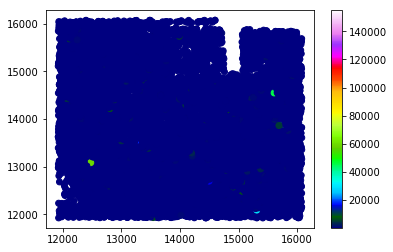

In [531]:
plt.scatter(xx_arr[valid], yy_arr[valid], c=err[valid],
           cmap=plt.cm.gist_ncar)
plt.colorbar()

In [533]:
err[valid].max()

155005.27

In [534]:
maxdex = np.argmax(err[valid])

In [535]:
print(xx_arr[valid][maxdex], yy_arr[valid][maxdex], err[valid][maxdex])


13709.786084707117 15008.900109751241 155005.27


In [536]:
data['base_GaussianFlux_flux'][valid][maxdex]

0.06089905692522539

In [537]:
calexp = butler.get('deepCoadd_calexp',
                   dataId={'filter':'HSC-R',
                          'tract':10054,
                          'patch':'3,3'})
calib = calexp.getCalib()

In [538]:
print(calib.getMagnitude(data['base_GaussianFlux_flux'][valid][maxdex]))

30.038473581855495


In [539]:
mags = calib.getMagnitude(data['base_GaussianFlux_flux'][valid])

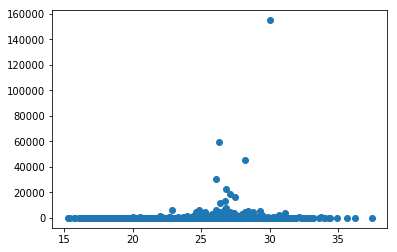

In [540]:
plt.scatter(mags,err[valid])
axes = plt.gca()
axes.xlim=(20,30)
plt.show()

In [541]:
data.schema.find('base_SdssCentroid_xSigma')

SchemaItem(key=Key<F>(offset=56, nElements=1), field=Field['F'](name="base_SdssCentroid_xSigma", doc="1-sigma uncertainty on x position", units="pixel"))